# Модель машинного обучения по управлению рисками и принятию объективных решений при покупке коров владельцу молочной фермы

Нам поступила задача от фермера, который владеей молочным хозяйством «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже.

Он просит нас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Необходимо создать **две прогнозные модели** для отбора бурёнок в поголовье:
 1. Первая будет прогнозировать возможный удой коровы (**целевой признак _Удой_**);
 2. Вторая — рассчитывать вероятность получить вкусное молоко от коровы (**целевой признак _Вкус молока_**).

С помощью модели нужно отобрать коров по **двум критериям**:
 - средний удой за год — **не менее 6000 килограммов**;
 - молоко должно быть **вкусным**.
 

## Описание данных

Работать предстоит с тремя датасетами:
 - `ferma_main.csv`
 - `ferma_dad.csv`
 - `cow_buy.csv`
 
1. Файл `ferma_main.csv` содержит данные о стаде фермера на текущий момент. Описание данных:
 - `id` — уникальный идентификатор коровы.
 - `Удой`, кг — масса молока, которую корова даёт в год (в килограммах).
 - `ЭКЕ` (Энергетическая кормовая единица) — показатель питательности корма коровы.
 - `Сырой протеин`, г — содержание сырого протеина в корме (в граммах).
 - `СПО` (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.
 - `Порода` — порода коровы.
 - `Тип пастбища` — ландшафт лугов, на которых паслась корова.
 - `порода папы_быка` — порода папы коровы.
 - `Жирность`,% — содержание жиров в молоке (в процентах).
 - `Белок`,% — содержание белков в молоке (в процентах).
 - `Вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
 - `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).
 
2. Файл `ferma_dad.csv` хранит имя папы каждой коровы в стаде фермера. Описание данных:
 - `id` — уникальный идентификатор коровы.
 - `Имя Папы` — имя папы коровы.
 
3. Файл `cow_buy.csv` — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Описание данных:
 - `Порода` — порода коровы.
 - `Тип пастбища` — ландшафт лугов, на которых паслась корова.
 - `порода папы_быка` — порода папы коровы.
 - `Имя_папы` — имя папы коровы.
 - `Текущая_жирность`,% — содержание жиров в молоке (в процентах).
 - `Текущий_уровень_белок`,% — содержание белков в молоке (в процентах).
 - `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).
 
Данные в файлах `ferma_main.csv` и `cow_buy.csv` похожи, но у датасета `cow_buy.csv` несколько особенностей.
 - Содержание белков и жиров в молоке указано на момент продажи — когда «ЭкоФерма» давала коровам свой корм.
 - Параметры корма ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение) отсутствуют.   Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%.
 - Кроме того, отсутствуют признаки Удой, кг и Вкус молока. Это целевые признаки, именно их предстоит предсказать

## Импорт необходимых библиотек

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score, r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Загрузка данных

In [3]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal=',')
cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')

Мы загрузили данные, теперь проверим их содержимое

In [4]:
ferma_main.info()
ferma_main.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
340,341,5497,14.7,1751,0.840,Вис Бик Айдиал,Равнинное,Айдиал,3.18,3.074,не вкусно,менее_2_лет
211,212,5415,11.9,1711,0.860,Вис Бик Айдиал,Равнинное,Айдиал,3.42,3.073,не вкусно,менее_2_лет
544,545,5380,12.4,1875,0.840,РефлешнСоверинг,Равнинное,Соверин,3.63,3.073,не вкусно,менее_2_лет
72,73,5718,13.7,2212,0.895,РефлешнСоверинг,Холмистое,Айдиалл,3.61,3.077,вкусно,более_2_лет
614,615,5741,12.9,1749,0.880,РефлешнСоверинг,Холмистое,Айдиал,3.44,3.076,вкусно,более_2_лет


В датасете 634 строки, отсутствуют пропуски. В некоторых столбцах, значения которых содержат числа имеется строковый тип данных (`ЭКЕ`, `СПО`, `Жирность`, `Белок`). Также, первое, что бросается в глаза это названия столбцов - они на русском, некоторые содердат пробелы. Устраним эти недочеты на этапе предобработки, чтобы можно было работать с данными.

In [5]:
ferma_dad.info()
ferma_dad.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


,id,Имя Папы
168,169,Буйный
543,544,Буйный
258,259,Барин
614,615,Буйный
340,341,Буйный


Пропусков нет, типы данных совпадают с содержанием столбцов. Единственная проблема в названии столбца `Имя папы`.

In [6]:
cow_buy.info()
cow_buy.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет


Датасет без пропусков, присуствуют несоответсвия в типах данных, а также названия столбцов на кириллице. Исправим ситуацию на этапе предобработки

#### Вывод
В ходе изучения данных ни в одном датасете не найдено пропусков. Во всех трех датасетах присутсвует одна и та же проблема - названия столбцов имеют пробелы, а также написаны кириллицей. В `ferma_main` и `cow_buy` присутствуют несоответствия в типах данных и содержаниях столбцов: столбцы, которые содержат числовые значения имеют строковый тип данных.

##  Предобработка данных

Начнем предобработку данных с того, чем мы закончили! Изменим названия столбцов в датасетах и изменим типы данных. Начнем с `ferma_main`. Сразу обозначим новые названия стобцов:
- `id` — `id`
 - `Удой` — `milk_production`
 - `ЭКЕ` (Энергетическая кормовая единица) — `efu` (energy feet unit)
 - `Сырой протеин`, г — `crude_protein`
 - `СПО` (Сахаро-протеиновое соотношение) — `spr` (sugar protein ratio)
 - `Порода` — `breed`
 - `Тип пастбища` — `pasture_type`
 - `порода папы_быка` — `bull_breed`
 - `Жирность`,% — `fat_content`
 - `Белок`,% — `protein_content`
 - `Вкус молока` — `taste`
 - `Возраст` — `age`

In [7]:
ferma_main.columns = ['id', 
                      'milk_production', 
                      'efu', 
                      'crude_protein', 
                      'spr', 
                      'breed', 
                      'pasture_type', 
                      'bull_breed', 
                      'fat_content', 
                      'protein_content', 
                      'taste', 
                      'age'] 

In [8]:
ferma_main.head()

,id,milk_production,efu,crude_protein,spr,breed,pasture_type,bull_breed,fat_content,protein_content,taste,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [9]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               634 non-null    int64  
 1   milk_production  634 non-null    int64  
 2   efu              634 non-null    float64
 3   crude_protein    634 non-null    int64  
 4   spr              634 non-null    float64
 5   breed            634 non-null    object 
 6   pasture_type     634 non-null    object 
 7   bull_breed       634 non-null    object 
 8   fat_content      634 non-null    float64
 9   protein_content  634 non-null    float64
 10  taste            634 non-null    object 
 11  age              634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


Дела сделано, тепеть обработаем оставшиеся датафреймы и начнем пойдем дальше. В `ferma_dad` изменим название столбца `Имя папы` на `dad_name`

In [10]:
ferma_dad.columns = ['id', 'dad_name']
ferma_dad.columns

Index(['id', 'dad_name'], dtype='object')

Теперь сделаем то же самое с `cow_buy`:
 - `Порода` - `breed`
 - `Тип пастбища` - `pasture_type`
 - `порода папы_быка` - `bull_breed`
 - `Имя_папы` - `dad_name`
 - `Текущая_жирность` - `fat_content`
 - `Текущий_уровень_белок` - `protein_content`
 - `Возраст` - `age`

In [11]:
cow_buy.columns = ['breed', 
                   'pasture_type', 
                   'bull_breed', 
                   'dad_name', 
                   'fat_content', 
                   'protein_content', 
                   'age']

In [12]:
cow_buy.head()

,breed,pasture_type,bull_breed,dad_name,fat_content,protein_content,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [13]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   breed            20 non-null     object 
 1   pasture_type     20 non-null     object 
 2   bull_breed       20 non-null     object 
 3   dad_name         20 non-null     object 
 4   fat_content      20 non-null     float64
 5   protein_content  20 non-null     float64
 6   age              20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Готово! Теперь нужно проверить датафреймы на наличие дубликатов, а также с помощью гистограмм обнаружить выбросы, если они присутсвуют. Для удобства напишем функцию.

In [14]:
def preprocessing_data(data):
    
    #Количество дубликатов
    print('Количество дубликатов:', data.duplicated().sum())
    print()
    #Неявные дубликаты в строковых столбцах
    object_columns = data.select_dtypes(include='object').columns
    for column in object_columns:
        print(f'Cписок уникальных значений для столбца {column}')
        if column in data.columns:
            print(data[column].unique())
            print()
            
    #Числовой тип данных
    numeric_columns = data.select_dtypes(include='number').columns
    
    # Уникальные значения в числовых столбцах
    for column in numeric_columns:
        print(f'Cписок уникальных значений для столбца {column}')
        if column in data.columns:
            print(data[column].sort_values().unique())
            print()
            
    #Гистограммы для числового типа данных
    for column in numeric_columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(data[column], bins=15, kde=True)
        plt.title(f'Гистограмма для {column}')
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.show() 
        

Количество дубликатов: 5

Cписок уникальных значений для столбца breed
['Вис Бик Айдиал' 'РефлешнСоверинг']

Cписок уникальных значений для столбца pasture_type
['Равнинное' 'Равнинные' 'Холмистое']

Cписок уникальных значений для столбца bull_breed
['Айдиал' 'Соверин' 'Айдиалл']

Cписок уникальных значений для столбца taste
['вкусно' 'не вкусно']

Cписок уникальных значений для столбца age
['более_2_лет' 'менее_2_лет']

Cписок уникальных значений для столбца milk_production
[ 5204  5207  5213  5215  5235  5242  5254  5257  5262  5263  5266  5268
  5281  5283  5284  5287  5288  5300  5302  5314  5315  5322  5331  5339
  5340  5342  5346  5347  5356  5358  5361  5367  5372  5374  5375  5376
  5378  5380  5381  5383  5392  5397  5411  5412  5415  5416  5417  5421
  5432  5439  5441  5442  5443  5446  5450  5456  5466  5467  5469  5477
  5492  5493  5497  5506  5509  5510  5513  5517  5520  5529  5533  5535
  5542  5544  5546  5561  5564  5565  5566  5568  5570  5571  5573  5574
  5583  5

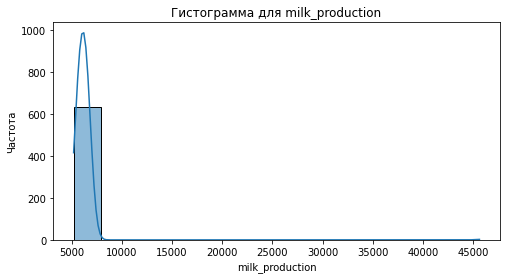

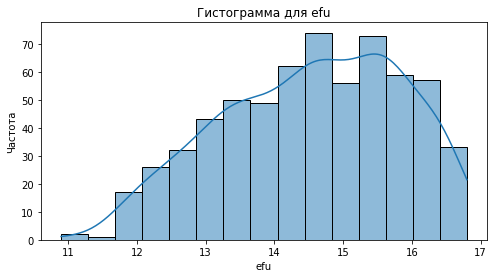

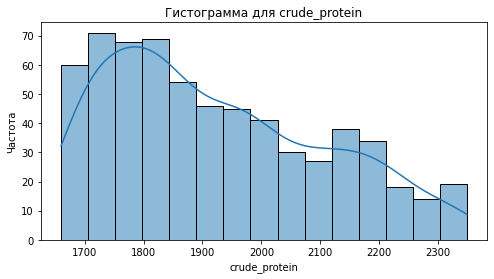

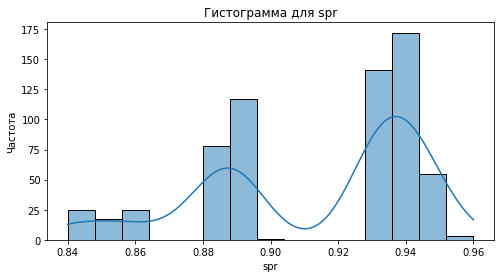

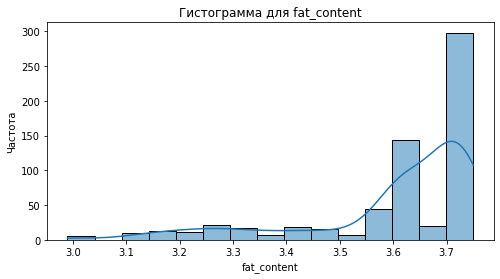

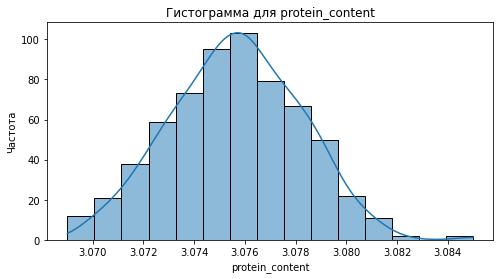

In [15]:
preprocessing_data(ferma_main.drop('id', 1))

В датасете найдено 5 явных дубликатов. Также обнаружены неявные дубликаты в категориальных столбцах и выбросы:
 1) В столбце `pasture_type` присутствуют одинаковые значения с разными склонениями, вероятно вызванные человеческим фактором (равнинное - равнинные)
 
 2) В столбце `bull_breed` присутствуют одинаковые значения с разным написанием, вероятно вызванные человеческим фактором (Айдиал - Айдиалл)
 
 3) Исследуя неявные дубликаты в количественных данных обнаружен выброс в столбце со значениями количества сырого протеина `milk_production`
 
 4) Гистограммы не так информативны ввиду разного разброса количественных значений. Исследуем их детальнее на этапе исследовательского анализа данных. 

In [16]:
ferma_main[ferma_main.duplicated()]

,id,milk_production,efu,crude_protein,spr,breed,pasture_type,bull_breed,fat_content,protein_content,taste,age
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


Мы имеем 5 абсолютно одинаковых строк в конце нашего датафрейма. Оставим только одну. 

In [17]:
ferma_main.drop_duplicates(keep='first', inplace=True)

In [18]:
ferma_main['pasture_type'] = ferma_main['pasture_type'].replace('Равнинные', 'Равнинное').str.lower()
ferma_main['pasture_type'].unique()

array(['равнинное', 'холмистое'], dtype=object)

In [19]:
ferma_main['bull_breed'] = ferma_main['bull_breed'].replace('Айдиалл', 'Айдиал')
ferma_main['bull_breed'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [20]:
ferma_main[ferma_main['milk_production'] == 45616]

,id,milk_production,efu,crude_protein,spr,breed,pasture_type,bull_breed,fat_content,protein_content,taste,age
16,17,45616,11.5,1675,0.93,Вис Бик Айдиал,холмистое,Айдиал,3.22,3.076,вкусно,более_2_лет


Т.к. в датафрейме только одна строка с аномально высоким значением, то просто удалим ее, т.к. она статистически исказит наше исследование. Вероятно при выгрузке данных произошла ошибка или же сыграл роль человеческий фактор.

In [21]:
ferma_main = ferma_main[ferma_main['milk_production'] != 45616]
ferma_main.shape

(628, 12)

In [22]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 628
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               628 non-null    int64  
 1   milk_production  628 non-null    int64  
 2   efu              628 non-null    float64
 3   crude_protein    628 non-null    int64  
 4   spr              628 non-null    float64
 5   breed            628 non-null    object 
 6   pasture_type     628 non-null    object 
 7   bull_breed       628 non-null    object 
 8   fat_content      628 non-null    float64
 9   protein_content  628 non-null    float64
 10  taste            628 non-null    object 
 11  age              628 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.8+ KB


C этим датасетом разобрались. Мы удалили менее 1% данных. Допустимые цифры. Мы почистили явные и неявные дубликаты в категориальных столбцах `pasture_type` и `bull_breed`, а также избавились от выбросов в столбце со значениями количества удоя `milk_production`.

Приступим к предобработке `ferma_dad`

In [23]:
preprocessing_data(ferma_dad.drop('id', 1))

Количество дубликатов: 625

Cписок уникальных значений для столбца dad_name
['Буйный' 'Соловчик' 'Барин' 'Геркулес']



В датафрейме выявлено 625 дубликатов, что странно. В остальном с датафреймом все впорядке. Проверим насколько эти дубликаты достоверны.

In [24]:
ferma_dad.duplicated().value_counts()

False    629
dtype: int64

Мы имеем 0 дубликатов в датафрейме, можно приступать к предобработке `cow_buy`

Количество дубликатов: 4

Cписок уникальных значений для столбца breed
['Вис Бик Айдиал' 'РефлешнСоверинг']

Cписок уникальных значений для столбца pasture_type
['холмистое' 'равнинное']

Cписок уникальных значений для столбца bull_breed
['Айдиал' 'Соверин']

Cписок уникальных значений для столбца dad_name
['Геркулес' 'Буйный' 'Барин' 'Соловчик']

Cписок уникальных значений для столбца age
['более_2_лет' 'менее_2_лет']

Cписок уникальных значений для столбца fat_content
[3.34 3.4  3.42 3.54 3.57 3.58 3.59 3.63 3.64 3.68 3.73 3.77]

Cписок уникальных значений для столбца protein_content
[3.046 3.053 3.055 3.061 3.065 3.069 3.073 3.074 3.075 3.076 3.079 3.081]



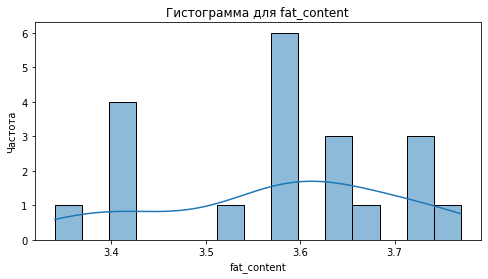

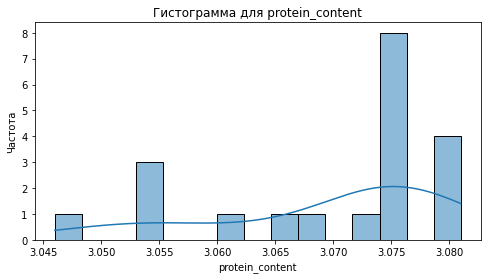

In [25]:
preprocessing_data(cow_buy)

___Что мы имеем___:  4 строки дубликата

In [26]:
cow_buy[cow_buy.duplicated()]

,breed,pasture_type,bull_breed,dad_name,fat_content,protein_content,age
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Дубликаты не такие уж и дубликаты. Т.к. в датафрейме всего 20 строк не будем их удалять. Дубликаты могут означать, что это две коровы от одного папы быка.

В датасете отсутствуют выбросы, дубликаты имеют объяснение, с ним мы закончили.

Финальным штрихом мы объединим датасеты ferma_main и ferma_dad по столбцу `id`

In [27]:
ferma_main = ferma_main.merge(ferma_dad, on='id', how='left')
ferma_main.head(5)

,id,milk_production,efu,crude_protein,spr,breed,pasture_type,bull_breed,fat_content,protein_content,taste,age,dad_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин


#### Вывод

В ходе предобработки данных мы выполнили следующие действия: 
 1) Изменили названия столбцов в трех датафреймах с кириллицы на латиницу;
 
 2) В датасетах `ferma_main` и `cow_buy` мы изменили типы данных в столбцах, содержащих числовые значения, с строковых на вещественночисленные;
 
 3) Написали функцию `preprocessing_data`, которая выявляет явные и неявные дубликаты в датафреймах, а также выводит спиок уникальных значений для столбцов с числовым типом данных и строит для них гистограммы;
 
 4) Удалили дубликаты в `ferma_main`, где было 5 повторяющихся строк. Вероятно ошибка при выгрузке или человеческий фактор.
 
 5) Привели значения столбца `pasture_type` к нижнему регистру, а также подправили орфографию в столбце `bull_breed`, чтобы в дальнейшем нашей модели было проще ориентироваться и находить закономерности в новых данных;
 
 6) Удалили одну строку с выбросов в столбце со значениями Удоя из датафрейма `milk_production` (менее 1% данных).
 
 7) Объединили датасеты `ferma_main` и `ferma_dad` для дальнейшего использования.

## Исследовательский анализ данных

Приступим к исследовательскому анализу с изучения данных из датасета `ferma_main`. 

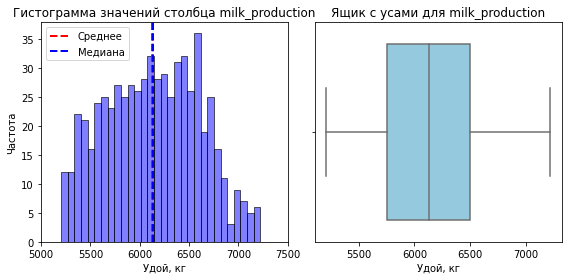

count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: milk_production, dtype: float64

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(ferma_main['milk_production'], kde=False, bins=30, color='blue', alpha=0.5, ax=axes[0])
axes[0].set_title('Гистограмма значений столбца milk_production')
axes[0].set_ylabel('Частота')
axes[0].set_xlabel('Удой, кг')
axes[0].set_xlim(5000, 7500)
axes[0].axvline(ferma_main['milk_production'].mean(), color='red', linestyle='dashed', linewidth=2, label='Среднее')
axes[0].axvline(ferma_main['milk_production'].median(), color='blue', linestyle='dashed', linewidth=2, label='Медиана')
axes[0].legend()

sns.boxplot(x=ferma_main['milk_production'], ax=axes[1], color='skyblue')
axes[1].set_title('Ящик с усами для milk_production')
axes[1].set_xlabel('Удой, кг')

plt.tight_layout()
plt.show()

ferma_main['milk_production'].describe()

Значения в столбце `milk_production` распределены нормально. Выбросов не обнаружено. Среднее и медиана примерно равны и составляют 6126 и 6133 соответственно. Минимальное значение количества удоя составило 5204, а максимальное 7222.

Далее проверим столбец `efu`, который содержит в себе значения ЭКЕ (Энергетическая кормовая единица) — показатель питательности корма коровы.

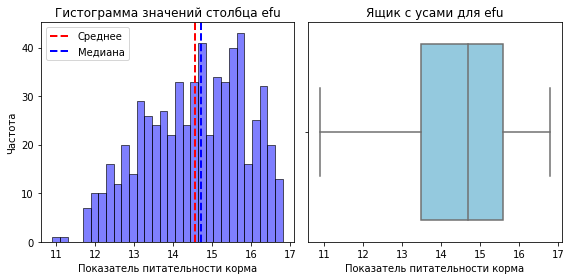

count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: efu, dtype: float64

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(ferma_main['efu'], kde=False, bins=30, color='blue', alpha=0.5, ax=axes[0])
axes[0].set_title('Гистограмма значений столбца efu')
axes[0].set_ylabel('Частота')
axes[0].set_xlabel('Показатель питательности корма')
axes[0].axvline(ferma_main['efu'].mean(), color='red', linestyle='dashed', linewidth=2, label='Среднее')
axes[0].axvline(ferma_main['efu'].median(), color='blue', linestyle='dashed', linewidth=2, label='Медиана')
axes[0].legend()

sns.boxplot(x=ferma_main['efu'], ax=axes[1], color='skyblue')
axes[1].set_title('Ящик с усами для efu')
axes[1].set_xlabel('Показатель питательности корма')

plt.tight_layout()
plt.show()

ferma_main['efu'].describe()

Значения в столбце с показателями ЭКЕ распределены нормально. Присутствует небольшая ассиметрия (отрицательная: левый хвост длиннее правого), что может указывать на особенности данных, а именно: чаще всего корм имеет ЭКЕ до 14 единиц. Также стоит обратить внимание на незначительные выбросы у левого хвоста гистограммы. Это может указывать на то, что некоторые коровы получают меньше энергии, чем нужно, что в следствии может плохо сказаться на качестве молока. Стоит пересмотреть их рацион питания. Минимальное значение ЭКЕ равно 10.9 ед., а максимальное 16.8 ед. Среднее и медиана составляют 14.5 и 14.7 соответственно. Незначительное различие. 

Проверим столбец `crude_protein` со значениями количества сырого протеина в корме. Корма, богатые сырым протеином, могут быть важными для животных, так как белок является важным элементом питания для роста, развития, обеспечения энергии и поддержания общего здоровья.

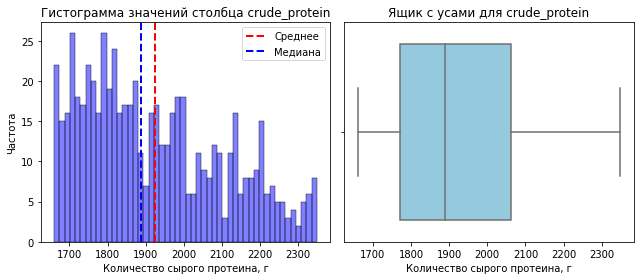

count     628.000000
mean     1923.759554
std       182.832816
min      1660.000000
25%      1771.750000
50%      1888.000000
75%      2062.250000
max      2349.000000
Name: crude_protein, dtype: float64

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

sns.histplot(ferma_main['crude_protein'], kde=False, bins=50, color='blue', alpha=0.5, ax=axes[0])
axes[0].set_title('Гистограмма значений столбца crude_protein')
axes[0].set_ylabel('Частота')
axes[0].set_xlabel('Количество сырого протеина, г')
axes[0].axvline(ferma_main['crude_protein'].mean(), color='red', linestyle='dashed', linewidth=2, label='Среднее')
axes[0].axvline(ferma_main['crude_protein'].median(), color='blue', linestyle='dashed', linewidth=2, label='Медиана')
axes[0].legend()

sns.boxplot(x=ferma_main['crude_protein'], ax=axes[1], color='skyblue')
axes[1].set_title('Ящик с усами для crude_protein')
axes[1].set_xlabel('Количество сырого протеина, г')

plt.tight_layout()
plt.show()

ferma_main['crude_protein'].describe()

Гистограмма указывает на то, что в основном количество сырого протеина в корме варьируется между 1660г - 1923г. Значения выше могут принадлежать к премиальным линейкам корма, которые могут быть предназначены для коров с дефицитом белка в организме. Очевидно, что даже если корова здорова, высокое содержание белка в корме положительно скажется на качестве молока и количестве удоя. Среднее и медианное значения равны 1924г и 1888г соответственно. Такое существенное различие объясняется наличием в данных кормов с высоким содержанием протеина. Минимальное и максимальное значения равны 1660г и 2349г соответственно.

Изучим  столбец `spr`, который содержит в себе значения СПО (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы. Это соотношение может быть полезным индикатором для оценки кормов с точки зрения их энергетической и белковой ценности. Например, высокое СПО может указывать на то, что корм содержит много сахара по сравнению с протеином, что может быть важным при формировании рационов для определенных видов животных, таких как лошади. С другой стороны, низкое СПО может быть предпочтительным для других видов, например, для кормления скота.

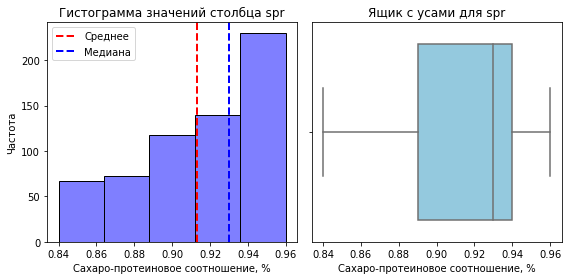

count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: spr, dtype: float64

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(ferma_main['spr'], kde=False, bins=5, color='blue', alpha=0.5, ax=axes[0])
axes[0].set_title('Гистограмма значений столбца spr')
axes[0].set_ylabel('Частота')
axes[0].set_xlabel('Сахаро-протеиновое соотношение, %')
axes[0].axvline(ferma_main['spr'].mean(), color='red', linestyle='dashed', linewidth=2, label='Среднее')
axes[0].axvline(ferma_main['spr'].median(), color='blue', linestyle='dashed', linewidth=2, label='Медиана')
axes[0].legend()

sns.boxplot(x=ferma_main['spr'], ax=axes[1], color='skyblue')
axes[1].set_title('Ящик с усами для spr')
axes[1].set_xlabel('Сахаро-протеиновое соотношение, %')

plt.tight_layout()
plt.show()

ferma_main['spr'].describe()

Изучив особенности кормления молочных коров, я обнаружил что для них требуется высокое содержание СПО для удовлетворения их энергетической потребности, т.к. это коровы с "высокой продуктивностью". Чаще всего стречаются корма со значением СПО 94-96%, что является особенностью кормления молочных коров. Минимальное значение СПО составило 84%, а максимальное 96%. Среднее и медиана равны 91% и 93% соответственно. 

Далее изучим столбец `breed` со значениями породы коров.

In [32]:
ferma_main['breed'].value_counts()

Вис Бик Айдиал     372
РефлешнСоверинг    256
Name: breed, dtype: int64

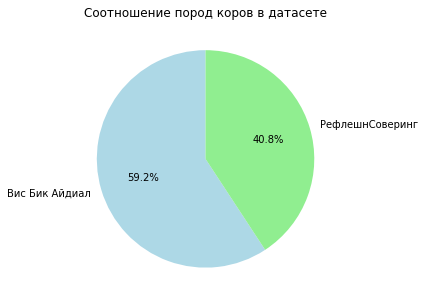

In [33]:
labels = ['Вис Бик Айдиал', 'РефлешнСоверинг']
sizes = [372, 256]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])
plt.title('Соотношение пород коров в датасете')
plt.show()

Видно, что в датасете преобладают коровы породы "Вис Бик Айдиал". Их доля в датасете составила 59.2% (372 коровы). Доля коров породы "РефлешнСоверинг" - 40.8% (256 коров.). Теперь попробуем проанализировать какая порода в среднем приносит больше молока.

In [34]:
(
    ferma_main.pivot_table(index='breed', values='milk_production', aggfunc='mean')
)

,milk_production
breed,
Вис Бик Айдиал,6099.405914
РефлешнСоверинг,6164.566406


Исходя из представленных данных РефлешнСоверинг приносит в среднем больший удой, нежели Вис Биг Айдиал. Разница составила около 65 кг на одну корову в среднем. Существенное различие. Наверное корову породы РефлешнСоверинг содержать дороже, поэтому их в датасете меньше, нежели Вис Биг Айдиал 

Следом на очереди тип пастбища `pasture_type`

In [35]:
ferma_main['pasture_type'].value_counts()

холмистое    350
равнинное    278
Name: pasture_type, dtype: int64

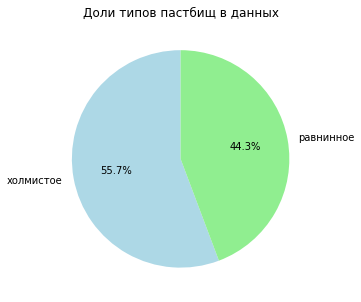

In [36]:
labels = ['холмистое', 'равнинное']
sizes = [350, 278]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])
plt.title('Доли типов пастбищ в данных')
plt.show()

Больше всего в датасете строк с холмистым типом пастбищ (55.7% данных). Оставшуюся часть (44.3%) составляют равнынные пастбища. Холмистых и равнинных пастбищ 350 и 278 соответственно. Проверим как тип пастбища влияет на удой.

In [37]:
(
     ferma_main.pivot_table(index='pasture_type', values='milk_production', aggfunc='mean')
)

,milk_production
pasture_type,
равнинное,6056.287770
холмистое,6181.314286


В среднем одна корова на холмистом пастбище производит на 125 кг молока больше, нежели равнинная корова.

Исследуем столбец `bull_breed` со значениями породы папы быка.

In [38]:
ferma_main['bull_breed'].value_counts()

Айдиал     317
Соверин    311
Name: bull_breed, dtype: int64

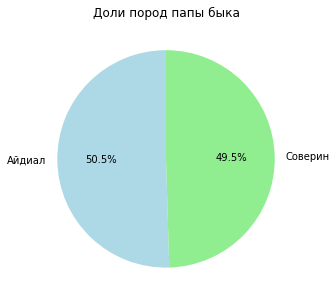

In [39]:
labels = ['Айдиал', 'Соверин']
sizes = [317, 311]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])
plt.title('Доли пород папы быка')
plt.show()

Доли почти совпадают! Мы имеем примерно равно распределение пород папы быка. "Айдиал" составляет 50.5% (317 строк), а "Соверин" - 49.5% (311 строк)

Следующий на очереди столбец со значениями процентного содержания жиров в молоке `fat_content`

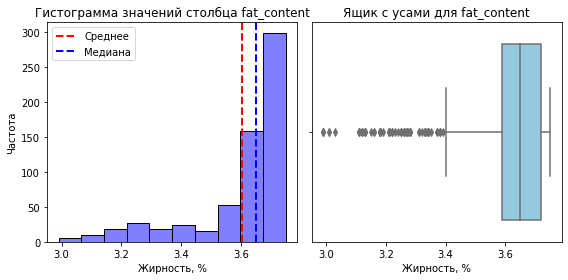

count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: fat_content, dtype: float64

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(ferma_main['fat_content'], kde=False, bins=10, color='blue', alpha=0.5, ax=axes[0])
axes[0].set_title('Гистограмма значений столбца fat_content')
axes[0].set_ylabel('Частота')
axes[0].set_xlabel('Жирность, %')
axes[0].axvline(ferma_main['fat_content'].mean(), color='red', linestyle='dashed', linewidth=2, label='Среднее')
axes[0].axvline(ferma_main['fat_content'].median(), color='blue', linestyle='dashed', linewidth=2, label='Медиана')
axes[0].legend()

sns.boxplot(x=ferma_main['fat_content'], ax=axes[1], color='skyblue')
axes[1].set_title('Ящик с усами для fat_content')
axes[1].set_xlabel('Жирность, %')

plt.tight_layout()
plt.show()

ferma_main['fat_content'].describe()

Мы имеем длинный левый хвост, что свидетельствует о неравномерном распределении. Чаще всего в датасете встречаются коровы, производящие молоко жирностью 3.6-3.7%, но встречаются и значения ниже, их достаточно много и все они находятся в диапазоне от 3-3.6% жирности. Они и составляют эту отрицательную ассиметрию. Среднее и медиана примерно равны, их значения 3.6% и 3.65% соответственно. Минимальное значение жирности составило 2.99%, а максимальное 3.75%

Исследуем значения столбца `protein_content` - содержание белка в молоке.

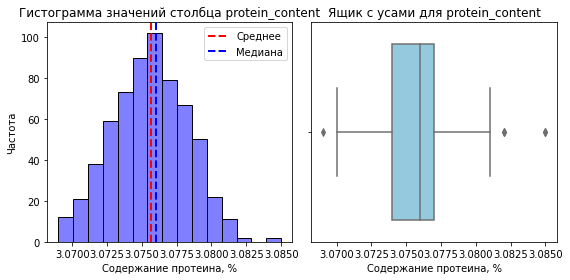

count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: protein_content, dtype: float64

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(ferma_main['protein_content'], kde=False, bins=15, color='blue', alpha=0.5, ax=axes[0])
axes[0].set_title('Гистограмма значений столбца protein_content')
axes[0].set_ylabel('Частота')
axes[0].set_xlabel('Содержание протеина, %')
axes[0].axvline(ferma_main['protein_content'].mean(), color='red', linestyle='dashed', linewidth=2, label='Среднее')
axes[0].axvline(ferma_main['protein_content'].median(), color='blue', linestyle='dashed', linewidth=2, label='Медиана')
axes[0].legend()

sns.boxplot(x=ferma_main['protein_content'], ax=axes[1], color='skyblue')
axes[1].set_title('Ящик с усами для protein_content')
axes[1].set_xlabel('Содержание протеина, %')

plt.tight_layout()
plt.show()

ferma_main['protein_content'].describe()

Наглядный пример нормального распределения данных. Хоть прикрепляй в учебник по статистике! Среднее и медиана равны 3.076 и 3.076 соответственно! Минимальное значение составило 3.069%, а максимальное - 3.085%. Есть значение, которое выбивается от основного набора данных - 3.085%. Такое незначительно высокое содержание протеина может указывать на особенности кормления коровы, период лактации, генетика. В основном все значения собраны в диапазоне между 3.074%-3.078%.

Теперь посмотрим насколько вкусно-невкусное молоко в данных.

In [42]:
ferma_main['taste'].value_counts()

вкусно       370
не вкусно    258
Name: taste, dtype: int64

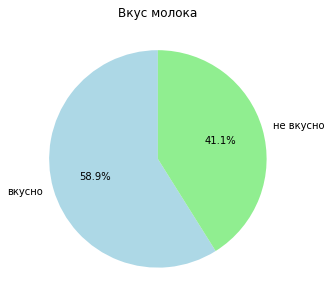

In [43]:
labels = ['вкусно', 'не вкусно']
sizes = [370, 258]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])
plt.title('Вкус молока')
plt.show()

Радует, что доля вкусного молока в датасете больше. Она составила 58/9% (370). Доля невкусного молока составила 41.1%.
Проверим какие породы чаще производят вкусное молоко. С помощью сводной сначала посчитаем количество вкусного и невкусного молока для каждой породы, а потом посчитаем соотношение вкусного молока ко всему. Чем ближе эта оценка будет к единице, тем больше доля вкусного молока у породы. 

In [44]:
taste_ratio = ferma_main.pivot_table(index='breed', columns='taste', values='id', aggfunc='count')
taste_ratio['ratio'] = taste_ratio['вкусно'] / (taste_ratio['вкусно'] + taste_ratio['не вкусно'])
taste_ratio

taste,вкусно,не вкусно,ratio
breed,,,
Вис Бик Айдиал,218,154,0.586022
РефлешнСоверинг,152,104,0.593750


Соотношение примерно одинаковое. То есть доля вкусного молока от общего числа у двух пород не отличается. 

Теперь признак возраст `age`

In [45]:
ferma_main['age'].value_counts()

более_2_лет    518
менее_2_лет    110
Name: age, dtype: int64

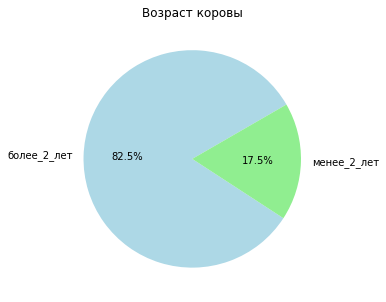

In [46]:
labels = ['более_2_лет', 'менее_2_лет']
sizes = [518, 110]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=30, colors=['lightblue', 'lightgreen'])
plt.title('Возраст коровы')
plt.show()

Подавляющее большинство коров в датасете старше двух лет. Их доля составила 82.5% (518 штук). Коров, чей возраст менее двух лет в датасете всего лишь 17.5% (110 штук). 

Теперь приступим к анализу столбца `dad_name`. На этапе предобработки мы выяснили, что столбец содержит 4 значения. Выведем их на экран.

In [47]:
ferma_main['dad_name'].value_counts()

Барин       240
Буйный      214
Соловчик    110
Геркулес     64
Name: dad_name, dtype: int64

А теперь построим круговую диаграмму для удобства.

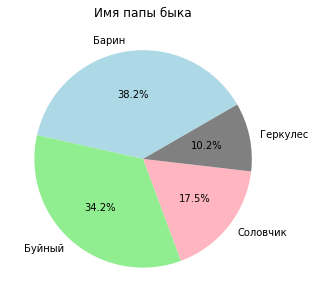

In [48]:
labels = ['Барин', 'Буйный', 'Соловчик', 'Геркулес']
sizes = [240, 215, 110, 64]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=30, colors=['lightblue', 'lightgreen', 'lightpink', 'grey'])
plt.title('Имя папы быка')
plt.show()

Больше всего в датасете коров от папы Барин. Их доля составила 38.2%. Следом, на втором месте коровы от Буйного - 34.2%. Меньше всего в датасете коров от Геркулеса и Соловчика. Их доли составили 10.2% и 17.5% соответственно. 

_____

Теперь приступим к анализу датасета `cow_buy` со значениями кандидатов на покупку со стороны заказчика. И первым делом мы исследуем признак `breed`

In [49]:
cow_buy['breed'].value_counts()

РефлешнСоверинг    11
Вис Бик Айдиал      9
Name: breed, dtype: int64

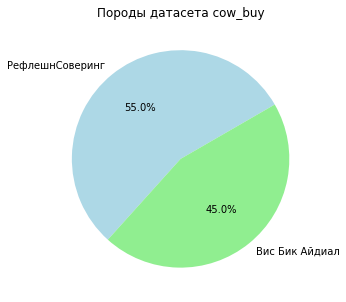

In [50]:
labels = ['РефлешнСоверинг', 'Вис Бик Айдиал']
sizes = [11, 9]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=30, colors=['lightblue', 'lightgreen'])
plt.title('Породы датасета cow_buy')
plt.show()

Почти равное количество. Рефлешн соверинг - 11 штук, а Вис Биг Айдиал - 9 штук

Далее идет столбец с типом пастбища

In [51]:
cow_buy['pasture_type'].value_counts()

равнинное    11
холмистое     9
Name: pasture_type, dtype: int64

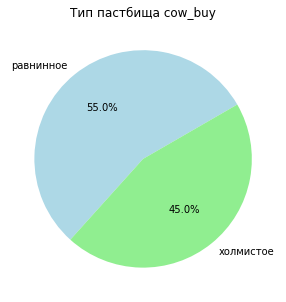

In [52]:
labels = ['равнинное', 'холмистое']
sizes = [11, 9]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=30, colors=['lightblue', 'lightgreen'])
plt.title('Тип пастбища cow_buy')
plt.show()

С типом пастбища такая же ситуация, что и с породами. Строк с равнинным типом пастбища - 11, а с холмистым - 9.

Исследуем значения столбца `bull_breed`

In [53]:
cow_buy['bull_breed'].value_counts()

Соверин    12
Айдиал      8
Name: bull_breed, dtype: int64

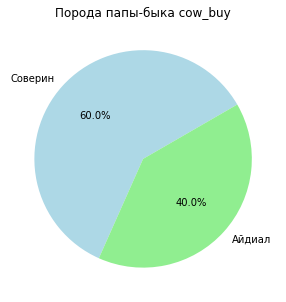

In [54]:
labels = ['Соверин', 'Айдиал']
sizes = [12, 8]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=30, colors=['lightblue', 'lightgreen'])
plt.title('Порода папы-быка cow_buy')
plt.show()

Соотношение 60% на 40% Соверин/Айдиал соответственно. Соверинов 12 штук, а Айдиалов 8. 

Исследуем значения столбца `dad_name`

In [55]:
cow_buy['dad_name'].value_counts()

Буйный      8
Геркулес    6
Барин       4
Соловчик    2
Name: dad_name, dtype: int64

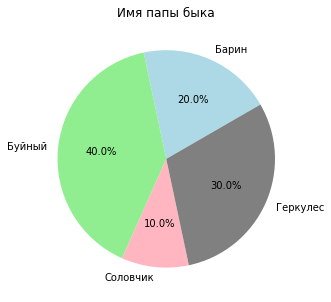

In [56]:
labels = ['Барин', 'Буйный', 'Соловчик', 'Геркулес']
sizes = [4, 8, 2, 6]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=30, colors=['lightblue', 'lightgreen', 'lightpink', 'grey'])
plt.title('Имя папы быка')
plt.show()

Чаще всего в датасете встречаются коровы от Буйного (40%). Сделом за ним идут коровы, чей папа Геркулес (30%). Затем, Барин (20%). Меньше всего в новом датасете коров от папы Буйного (10%)

Проверим столбец с текущей жирностью молока на момент продажи коров. 

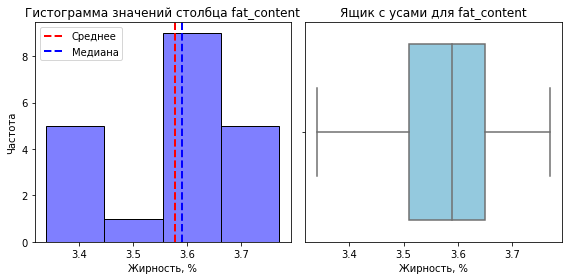

count    20.000000
mean      3.577500
std       0.126818
min       3.340000
25%       3.510000
50%       3.590000
75%       3.650000
max       3.770000
Name: fat_content, dtype: float64

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(cow_buy['fat_content'], kde=False, bins=4, color='blue', alpha=0.5, ax=axes[0])
axes[0].set_title('Гистограмма значений столбца fat_content')
axes[0].set_ylabel('Частота')
axes[0].set_xlabel('Жирность, %')
axes[0].axvline(cow_buy['fat_content'].mean(), color='red', linestyle='dashed', linewidth=2, label='Среднее')
axes[0].axvline(cow_buy['fat_content'].median(), color='blue', linestyle='dashed', linewidth=2, label='Медиана')
axes[0].legend()

sns.boxplot(x=cow_buy['fat_content'], ax=axes[1], color='skyblue')
axes[1].set_title('Ящик с усами для fat_content')
axes[1].set_xlabel('Жирность, %')

plt.tight_layout()
plt.show()

cow_buy['fat_content'].describe()

Чаще всего встречается молоко жирностью 3.6%. Среднее и медиана равны 3.58% и 3.59% соответственно. Трудно сделать вывод о характере распределения, т.к. слишком мало наблюдений в данных. 

Исследуем текущий уровень белка.

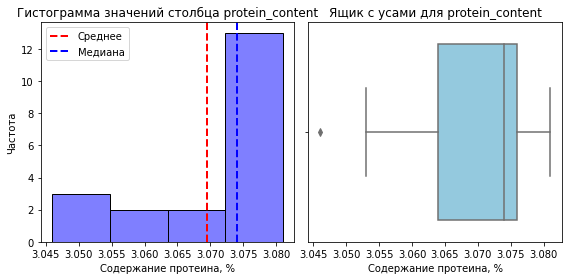

count    20.000000
mean      3.069500
std       0.010339
min       3.046000
25%       3.064000
50%       3.074000
75%       3.076000
max       3.081000
Name: protein_content, dtype: float64

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(cow_buy['protein_content'], kde=False, bins=4, color='blue', alpha=0.5, ax=axes[0])
axes[0].set_title('Гистограмма значений столбца protein_content')
axes[0].set_ylabel('Частота')
axes[0].set_xlabel('Содержание протеина, %')
axes[0].axvline(cow_buy['protein_content'].mean(), color='red', linestyle='dashed', linewidth=2, label='Среднее')
axes[0].axvline(cow_buy['protein_content'].median(), color='blue', linestyle='dashed', linewidth=2, label='Медиана')
axes[0].legend()

sns.boxplot(x=cow_buy['protein_content'], ax=axes[1], color='skyblue')
axes[1].set_title('Ящик с усами для protein_content')
axes[1].set_xlabel('Содержание протеина, %')

plt.tight_layout()
plt.show()

cow_buy['protein_content'].describe()

В основном в датасете коровы, которые на момент продажи производили молоко с высоким содержанием белка. Большинство значений собраны в диапазоне 3.075% - 3.080%. 

In [59]:
cow_buy['age'].value_counts()

более_2_лет    15
менее_2_лет     5
Name: age, dtype: int64

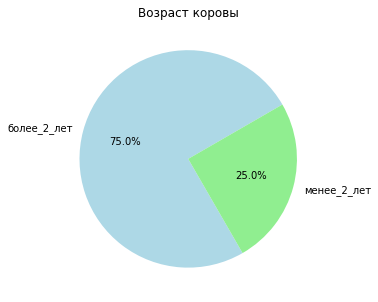

In [60]:
labels = ['более_2_лет', 'менее_2_лет']
sizes = [15, 5]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=30, colors=['lightblue', 'lightgreen'])
plt.title('Возраст коровы')
plt.show()

Большинство коров, как и в `ferma_main` имеют возраст более 2-х лет (75% данных). Оставшуюся долю (25%) составили молодые коровы возрастом до 2-х лет

#### Вывод

Мы произвели достаточно большое исследование в ходе которого было обнаружено множество закономерностей. Расскажу обо всем по порядку. Начну я с датасета `ferma_main`:

 1) Признак, содержащий значения Удоя `milk_production` имеет нормальное распределение со средним и медианой равными 6126 кг и 6133 кг соответственно. Выбросов обнаружено не было;
 
 2) Признак, содержащий в себе значения ЭКЕ `efu` имеет небольшую отрицательную ассиметрию. На практике это может означать, что чаще всего корм в данных представлен с меньшим значением ЭКЕ, чем среднее по выборке. Если представить этот тезис в цифрах, то в среднем корм коров в датасете имеет 14.5 ЭКЕ, но многих коров кормят кормом, который содержит меньшее количетсво ЭКЕ. Скорее всего для коров нормально получать такое кол-во корма. Стоит отметить незначительные выбросы на отметке ниже 11.5 единиц. Вероятно некоторые коровы получают энергии гораздо меньше положенного. 
 
 3) Что касается содержания протеина в кормах, то судя по гистограмме столбца `crude_protein` в основном количество сырого протеина в корме варьируется между 1660г - 1923г. Значения выше могут принадлежать к премиальным линейкам корма, которые могут быть предназначены для коров с дефицитом белка в организме. Очевидно, что даже если корова здорова, высокое содержание белка в корме положительно скажется на качестве молока и количестве удоя. Среднее и медианное значения равны 1924г и 1888г соответственно. Такое существенное различие объясняется наличием в данных кормов с высоким содержанием протеина. 
 
 4) Изучив особенности кормления молочных коров, я обнаружил что для них требуется высокое содержание СПО  (`spr`) для удовлетворения их энергетической потребности, т.к. это коровы с "высокой продуктивностью". Чаще всего стречаются корма со значением СПО 94-96%, что является особенностью кормления молочных коров. Минимальное значение СПО составило 84%, а максимальное 96%. Среднее и медиана равны 91% и 93% соответственно.
 
 5) Исследовав столбец с породами коров датасета `breed` выяснилось, что в датасете преобладают коровы породы "Вис Бик Айдиал". Их доля в датасете составила 59.2% (372 коровы). Доля коров породы "РефлешнСоверинг" - 40.8% (256 коров.). При этом, создав сводную таблицу по среднему количеству удоя в зависимости от породы коровы выяснилось, что РефлешнСоверинг приносит в среднем больший удой, нежели Вис Биг Айдиал. Разница составила около 65 кг на одну корову в среднем. Существенное различие. Наверное корову породы РефлешнСоверинг содержать дороже, поэтому их в датасете меньше, нежели Вис Биг Айдиал.
 
 6) Что касается типов пастбищ `pasture_type`, то тут были выявлены следующие закономерности: больше всего в датасете строк с холмистым типом пастбищ (55.7% данных). Оставшуюся часть (44.3%) составляют равнынные пастбища. Холмистых и равнинных пастбищ 350 и 278 соответственно. При этом, в среднем одна корова на холмистом пастбище производит на 125 кг молока больше, нежели равнинная корова.
 
 7) Мы имеем примерно равно распределение пород папы быка `bull_breed`. "Айдиал" составляет 50.5% (317 строк), а "Соверин" - 49.5% (311 строк).
 
 8) В гистограмме значений столбца `fat_content` мы имеем длинный левый хвост, что свидетельствует о неравномерном распределении. Чаще всего в датасете встречаются коровы, производящие молоко жирностью 3.6-3.7%, но встречаются и значения ниже, их достаточно много и все они находятся в диапазоне от 3-3.6% жирности. Они и составляют эту отрицательную ассиметрию. Среднее и медиана примерно равны, их значения 3.6% и 3.65% соответственно. Минимальное значение жирности составило 2.99%, а максимальное 3.75%
 
 9) Столбец `protein_content` показал наглядный пример нормального распределения данных. Среднее и медиана равны 3.076 и 3.076 соответственно. Минимальное значение составило 3.069%, а максимальное - 3.085%. Есть значение, которое выбивается от основного набора данных - 3.085%. Такое незначительно высокое содержание протеина может указывать на особенности кормления коровы, период лактации, генетика. В основном все значения собраны в диапазоне между 3.074%-3.078%.
 
 10) Столбец со значениями вкуса молока каждой коровы `taste` поведал нам, что доля вкусного молока в датасете больше. Она составила 58.9% (370). Доля невкусного молока составила 41.1%. При этом соотношение вкусного молока к общему количеству наблюдений у обеих пород одинаково. 
 
 11) Подавляющее большинство коров в датасете старше двух лет. Их доля составила 82.5% (518 штук). Коров, чей возраст менее двух лет в датасете всего лишь 17.5% (110 штук) - столбец `age`.
 
 12) Больше всего в датасете коров от папы Барин. Их доля составила 38.2%. Следом, на втором месте коровы от Буйного - 34.2%. Меньше всего в датасете коров от Геркулеса и Соловчика. Их доли составили 10.2% и 17.5% соответственно (`dad_name`)

По датасету cow_buy особо нечего было сказать, т.к. в нем было всего 20 наблюдений. Вот что удалось выяснить:
 
 1) Породы: Рефлешн соверинг - 11 штук, а Вис Биг Айдиал - 9 штук
 
 2) С типом пастбища такая же ситуация, что и с породами. Строк с равнинным типом пастбища - 11, а с холмистым - 9.
 
 3) Порода папы быка: соотношение 60% на 40% Соверин/Айдиал соответственно. Соверинов 12 штук, а Айдиалов 8.
 
 4) Чаще всего в датасете встречаются коровы от Буйного (40%). Сделом за ним идут коровы, чей папа Геркулес (30%). Затем, Барин (20%). Меньше всего в новом датасете коров от папы Буйного (10%)
 
 5) Чаще всего встречается молоко жирностью 3.6%. 
 
 6) В основном в датасете коровы, которые на момент продажи производили молоко с высоким содержанием белка. Большинство значений собраны в диапазоне 3.075% - 3.080%.
 
 7) Большинство коров, как и в ferma_main имеют возраст более 2-х лет (75% данных). Оставшуюся долю (25%) составили молодые коровы возрастом до 2-х лет

## Корреляционный анализ

Проведем корреляционный анализ признаков датасета `ferma_main`. Корреляционный анализ нужен для того, чтобы лучше понимать взаимоотношения признаков друг с другом и с целевой переменной. Если мы понимаем, что в датасете несколько признаков коррелируют между собой, то мы оставляем только тот, что сильнее коррелирует с целевой переменной. 

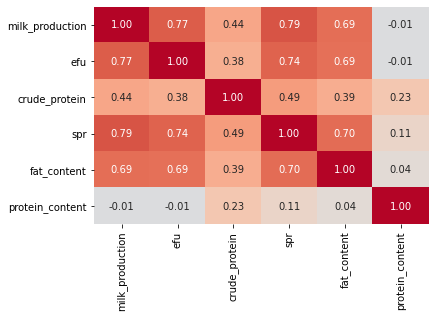

In [61]:
sns.heatmap(ferma_main.drop('id', 1).corr(method='spearman'), cmap='coolwarm', annot=True, fmt='.2f', center= 0, cbar=False)
plt.show()

В нашем случае целевой признак `milk_production`. Вот какие выводы мы можем сделать из корреляционной матрицы:
 
 1) Сахаро-протеиновое соотношение  `spr` имеет наиболее высокую корреляцию с целевым признаком 0.79. Согласно Шкале Чеддока мы имеем высокую тесноту связи этих признаков;

 2) Такая же высокая теснота связи имеется между целевым признаком и ЭКЕ `efu`. Она составила 0.77;
 
 3) Заметная связь обнаружена у целевого признака с признаком `fat_content` - 0.69;

Далее построим диаграммы рассеяния целевого признака `milk_production` и всех количественных признаков датасета с учетом значений категориальных признаков. 

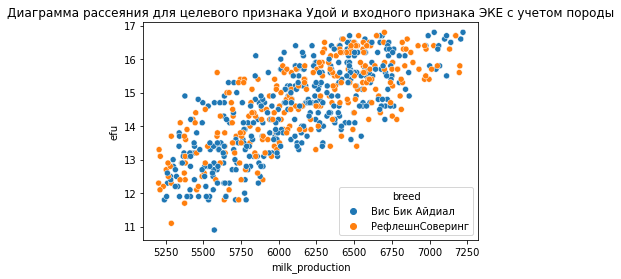

In [62]:
sns.scatterplot(data=ferma_main, x='milk_production', y='efu', hue='breed')
plt.title('Диаграмма рассеяния для целевого признака Удой и входного признака ЭКЕ с учетом породы')
plt.show()

У целевого признака `milk_production` и входного `efu` по каждой породе наблюдается линейная зависимость. Что и показала корреляционная матрица. Но линейная зависимость не такая уж и сильная. На диаграмме слишком большая дисперсия.

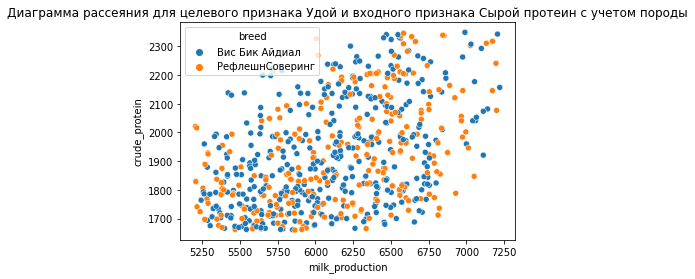

In [63]:
sns.scatterplot(data=ferma_main, x='milk_production', y='crude_protein', hue='breed')
plt.title('Диаграмма рассеяния для целевого признака Удой и входного признака Сырой протеин с учетом породы')
plt.show()

Диаграмма рассеяния указывает на то, что линейная связь между Удоем и Сырым протеином в корме практически отсутствует.

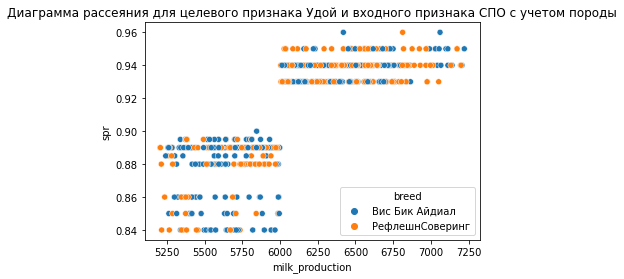

In [64]:
sns.scatterplot(data=ferma_main, x='milk_production', y='spr', hue='breed')
plt.title('Диаграмма рассеяния для целевого признака Удой и входного признака СПО с учетом породы')
plt.show()

Наблюдения в диаграмме рассеяния разделены на два кластера. Связь можно охарактеризовать, как нелинейную. Причем границей можно считать `spr` = 0.90. Добавим с датасет новую категориальную переменную, где будут отображены строки со значением `spr` менее 0.90 и более 0.90. На этапе подготовке данных для обучения моделей введем дополнительный признак в датасет

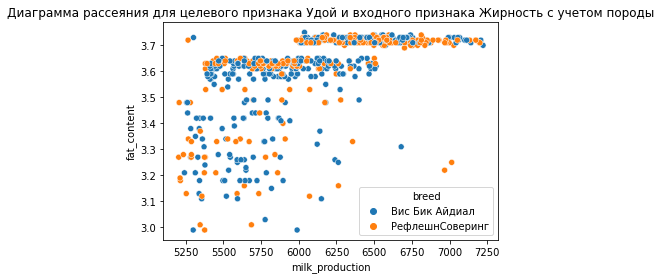

In [65]:
sns.scatterplot(data=ferma_main, x='milk_production', y='fat_content', hue='breed')
plt.title('Диаграмма рассеяния для целевого признака Удой и входного признака Жирность с учетом породы')
plt.show() 

У Жирности производимого молока и Удоя отсутствует линейная зависимость.

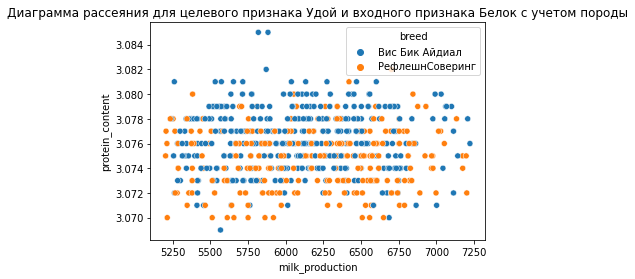

In [66]:
sns.scatterplot(data=ferma_main, x='milk_production', y='protein_content', hue='breed')
plt.title('Диаграмма рассеяния для целевого признака Удой и входного признака Белок с учетом породы')
plt.show() 

У этих признаков отсутствует линейная зависимость

Для того, чтобы исключить мультиколлинеарность признаков в модели логистической регрессии, коэффициент корреляции Пирсона нам не подойдет. Можем использовать коэффициент корреляции Фи из библиотеки `phik`

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



👍 phik





In [67]:
ferma_main.drop('id', 1).phik_matrix()

interval columns not set, guessing: ['milk_production', 'efu', 'crude_protein', 'spr', 'fat_content', 'protein_content']


,milk_production,efu,crude_protein,spr,breed,pasture_type,bull_breed,fat_content,protein_content,taste,age,dad_name
milk_production,1.000000,0.719239,0.465118,0.661615,0.161643,0.279645,0.518114,0.706516,0.063045,0.178281,0.998071,0.432018
efu,0.719239,1.000000,0.458283,0.591190,0.123086,0.106758,0.171355,0.715914,0.000000,0.272265,0.771596,0.069197
crude_protein,0.465118,0.458283,1.000000,0.386550,0.090971,0.097165,0.000000,0.397691,0.202386,0.173817,0.353829,0.119768
spr,0.661615,0.591190,0.386550,1.000000,0.062660,0.155349,0.425601,0.645581,0.073787,0.572702,0.744410,0.409142
breed,0.161643,0.123086,0.090971,0.062660,1.000000,0.213218,0.089330,0.222825,0.361851,0.000000,0.057295,0.382644
pasture_type,0.279645,0.106758,0.097165,0.155349,0.213218,1.000000,0.000000,0.000000,0.099908,0.269063,0.128455,0.233149
bull_breed,0.518114,0.171355,0.000000,0.425601,0.089330,0.000000,1.000000,0.000000,0.134582,0.000000,0.355817,0.982909
fat_content,0.706516,0.715914,0.397691,0.645581,0.222825,0.000000,0.000000,1.000000,0.000000,0.198793,0.677913,0.090409
protein_content,0.063045,0.000000,0.202386,0.073787,0.361851,0.099908,0.134582,0.000000,1.000000,0.143857,0.000000,0.091102
taste,0.178281,0.272265,0.173817,0.572702,0.000000,0.269063,0.000000,0.198793,0.143857,1.000000,0.165974,0.000000


Что мы имеем:
1) Сильная корреляция между входными признаками `milk_production` и `age` - 0.998. При этом с целевой переменной `taste` у входных признаков примерно одинаковая корреляция. То есть при обучении модели стоит исключить один из признаков. 

2) Также сильная корреляция наблюдается у признаков `dad_name` и `bull_breed` - 0.982. Это вполне объяснимо причинно-следственно, ведь у коров, чей папа имеет одно и то же имя сходится признак значения его породы, т.к. это один и тот же бык. При этом с целевой переменной они вообще никак не коррелируют. Для исключения мультиколлинеарности уберем один признак при обучении модели. 

Корреляция в остальных случаях считается допустимой для обучения модели логистической регрессии.

#### Вывод

Проведя корреляционный анализ признаков датасета мы можем сделать сделать следующий вывод о характере зависимости данных:
 1) Целевой признак `milk_production` имеет слабую линейную связь с признаком `efu`. Наблюдается большая дисперсия. При этом коэффициент корреляции составил 0.77. При обучении модели стоит логарифмировать этот признак или возвести его в квадрат. 
 
 2) Также обнаружена тесная связь между целевым признаком и `spr`, хоть и не линейная. Этот признак лучше будет изменить на категориальный. На диаграмме рассеяния наблюдения разделились на два кластера с порогом 0.90. Добавим новый признак `spr_bin`, который будет содержать информацию о том больше или меньше наблюдение выбранного порога.
 
 3) В ходе анализа было обнаружено, что признаки `fat_content`, `crude_protein` и `protein_content` не имеют линейной зависимости.
 
 4) При обучении модели логистической регрессии необходимо исключить один из признаков `age` или `milk_production`, `dad_name` или `bull_breed`

## Обучение модели линейной регрессии

#### Первая модель линейной регрессии

Приступим к обучению нашей первой модели, но для начала подготовим данные. В качестве целевого признака мы используем переменную `milk_production`.

Определимся с тем, какие признаки мы оставим в датасете, а какие уберем:
 1) `id` не несет никакой информации, для линейной регрессии он будет лишним. Это по сути порядковый номер коровы.
 
 2) `efu`, `crude_protein`, `spr` - это все необходимые признаки. Питание коровы напрямую влияет на размер удоя, поэтому их мы оставляем.
 
 3) `pasture_type` - это условие, которые также влияют на целевой признак. 
 
 4) `breed`, `bull_breed`, `age` - это все что связано с генетикой и возрастом коровы. Генетика сильно влияет на удой, как мы выяснили в ходе исследовательского анализа данных, поэтому пренебрегать этими признаками будет неправильно.
 
 5) `fat_content`, `protein_content` - эти признаки мы также учтем при обучении нашей модели
 
 6) `taste` - этот признак мы не будем использовать при прогнозировании удоя, т.к. ву рамках линейной регрессии он не является информативным.
 
 Таким образом мы имеем:
 
 1) **Количественные признаки** `efu`, `crude_protein`, `spr`, `fat_content`, `protein_content`
 
 2) **Категориальные признаки** `pasture_type`, `age`,  `breed`, `bull_breed`, среди них все признаки - бинарные.

In [68]:
RANDOM_STATE=1234

features = ferma_main.drop(['id', 'taste', 'milk_production', 'dad_name'], 1)
target = ferma_main['milk_production']

cat_col_name = ['pasture_type', 'age', 'breed', 'bull_breed']
num_col_name = ['efu', 'crude_protein', 'spr', 'fat_content', 'protein_content']

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=RANDOM_STATE)

Далее кодируем категориальные признаки. После кодировки сохраним названия новых столбцов в новую переменную `encoder_col_names`.

In [69]:
encoder = OneHotEncoder(sparse=False, drop='first')

X_train_ohe = encoder.fit_transform(X_train[cat_col_name])
X_test_ohe = encoder.transform(X_test[cat_col_name])

encoder_col_names = encoder.get_feature_names()

Теперь приступим к масштабированию количетсвенных признаков

In [70]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[num_col_name])
X_test_scaled = scaler.transform(X_test[num_col_name])

Далее создадим датафреймы из отмасштабированных и кодированных признаков и объединим их в обучающую и тестовую выборку входных признаков

In [71]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_name)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_name)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

Далее обучим нашу модель и оценим ее качество на тестовой выборка с помощью метрики R2. Коэффициент детерминации R2 оценивает обобщающую способность модели. Эта метрика объясняет насколько хорошо модель объясняет целевой признак по входным. 

In [72]:
model_lr1 = LinearRegression()
model_lr1.fit(X_train, y_train)
pred = model_lr1.predict(X_test)

print(f'Значение метрики R2 для модели model_lr1 = {r2_score(y_test, pred):.3f}')

Значение метрики R2 для модели model_lr1 = 0.811


Далее проведем анализ остатков. Напомним, что основным правилом анализа остатков является условие, при котором модель, правильно подобранная к исходным данным не оставит в остатках никаких закономерностей. В противном случае содель не учитывает какие-либо события, пренебрегает свойствами входных признаков и их зависимостью с целевым. Мы изучим случайность остатков и их дисперсию. 

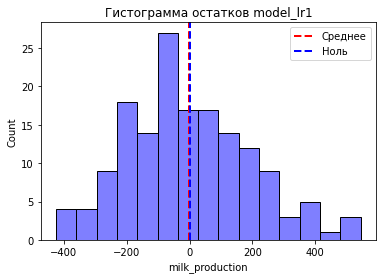

Среднее по остаткам -2.869


In [73]:
sns.histplot(y_test - pred, kde=False, 
             bins=15, color = 'blue', alpha=0.5)
plt.title('Гистограмма остатков model_lr1')

plt.axvline((y_test - pred).mean(), color='red', linestyle='dashed', linewidth=2, label='Среднее')
plt.axvline(0, color='blue', linestyle='dashed', linewidth=2, label='Ноль')
plt.legend()
plt.show()
print(f'Среднее по остаткам {(y_test - pred).mean():.3f}')

Гистограмма чуть смещена влево. При этом распределение стремится к нормальному. Модель предсказывает значения чуть больше реальных. 

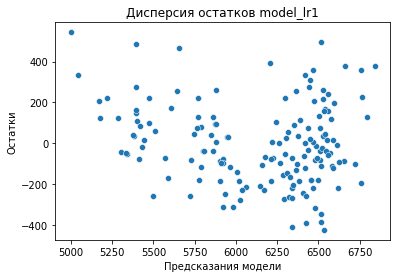

Дисперсия остатков 38823.33513818005


In [74]:
sns.scatterplot(x=pred, y=y_test - pred)
plt.xlabel('Предсказания модели')
plt.ylabel('Остатки')
plt.title('Дисперсия остатков model_lr1')
plt.show()
print(f'Дисперсия остатков {(y_test - pred).var()}')

Диаграмма рассеяния показала, что при дисперсия ошибки уменьшается при увеличении значений целевого признака. 


    
<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:

    
    
- есть графический анализ остатков и вывод о недостаточной гомоскедастичности на месте     
     
    
    
          

##### Вывод по model_lr_1

1) Коэффициент детерминации R2 нашей модели равен 0.811. Предсказания нашей модели в 81% случаев ближе к истине, чем среднее значение целевого  признака.

2) Анализ остатков показал нам, что ошибки модели имеют нормальное распределение, с небольшим смещением влево - модель предсказывает целевой признак чуть больше, чем он есть на самом деле. Также анализ дисперсии остатков показал нам, что при увеличении предсказаний дисперсия ошибки уменьшается. Сама дисперсия составила 38823. Это может влиять на эффективность и интерпретацию модели. Как вариант можно добавить новые входные признаки или преобразовать уже имеющиеся.

#### Вторая модель линейной регрессии

В ходе корреляционного анализа мы решили изменить входные признаки датасета, а именно:

1) Логарифмировать или возвести в квадрат признак `efu`. В нашем случае мы просто добавим в датасет новый признак `efu2`

2) Добавить в датасет новый бинарный признак `spr090`, значения которого будут созданы на основе сравнения данных признака `spr` с выбраным порогом 0.90

Приступим к подготовке данных к обучению 

In [75]:
ferma_main['efu2'] = ferma_main['efu'] **2

def spr_0915(value):
    if value < 0.915:
        return 'ниже порога'
    else:
        return 'выше порога'
    
ferma_main['spr0915'] = ferma_main['spr'].apply(spr_0915)

ferma_main.sample(5)

,id,milk_production,efu,crude_protein,spr,breed,pasture_type,bull_breed,fat_content,protein_content,taste,age,dad_name,efu2,spr0915
416,418,6449,16.2,1860,0.94,РефлешнСоверинг,равнинное,Соверин,3.73,3.075,не вкусно,более_2_лет,Соловчик,262.44,выше порога
466,468,5692,14.1,1809,0.89,РефлешнСоверинг,холмистое,Соверин,3.61,3.076,вкусно,более_2_лет,Барин,198.81,ниже порога
500,502,5374,12.6,1784,0.85,РефлешнСоверинг,холмистое,Соверин,3.21,3.077,не вкусно,менее_2_лет,Барин,158.76,ниже порога
83,85,6686,16.7,2018,0.93,Вис Бик Айдиал,холмистое,Айдиал,3.72,3.070,вкусно,более_2_лет,Барин,278.89,выше порога
312,314,6358,15.6,1824,0.94,РефлешнСоверинг,равнинное,Айдиал,3.73,3.071,вкусно,более_2_лет,Буйный,243.36,выше порога


Новые признаки добавлены правильно! Теперь обозначим итоговые признаки, которые будут использованы для обучения нашей модели:

 1) **Количественные признаки** `efu2`, `crude_protein`, `fat_content`, `protein_content`
 
 2) **Категориальные признаки** `pasture_type`, `age`,  `breed`, `bull_breed`, `spr0915` среди них все признаки - бинарные.
 
Готово! Теперь повторим шаги предыдущей модели.

In [76]:
features2 = ferma_main.drop(['id', 'efu', 'spr', 'milk_production', 'dad_name'], 1)
target2 = ferma_main['milk_production']

cat_col_name2 = ['pasture_type', 'age', 'breed', 'bull_breed', 'spr0915']
num_col_name2 = ['efu2', 'crude_protein', 'fat_content', 'protein_content']

X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target2, random_state=RANDOM_STATE)

#Кодируем категориальные признаки
encoder2 = OneHotEncoder(sparse=False, drop='first')
X_train2_ohe = encoder2.fit_transform(X_train2[cat_col_name2])
X_test2_ohe = encoder2.transform(X_test2[cat_col_name2])

encoder2_col_names = encoder2.get_feature_names()

#Масштабируем количественные признаки
scaler2 = StandardScaler()
X_train2_scaled = scaler2.fit_transform(X_train2[num_col_name2])
X_test2_scaled = scaler2.transform(X_test2[num_col_name2])

#Cоздаем датафреймы обработанных признаков и объединяем их в итоговые выборки с входными признаками
X_train2_ohe = pd.DataFrame(X_train2_ohe, columns=encoder2_col_names)
X_test2_ohe = pd.DataFrame(X_test2_ohe, columns=encoder2_col_names)

X_train2_scaled = pd.DataFrame(X_train2_scaled, columns=num_col_name2)
X_test2_scaled = pd.DataFrame(X_test2_scaled, columns=num_col_name2)

X_train2 = pd.concat([X_train2_ohe, X_train2_scaled], axis=1)
X_test2 = pd.concat([X_test2_ohe, X_test2_scaled], axis=1)

#Создаем и обучаем нашу модель
model_lr2 = LinearRegression()
model_lr2.fit(X_train2, y_train2)
pred2 = model_lr2.predict(X_test2)

Далее посчитаем значение метрики R2 для model_lr2

In [77]:
print(f'Значение метрики R2 для модели model_lr2 = {r2_score(y_test2, pred2):.3f}')

Значение метрики R2 для модели model_lr2 = 0.830


И проведем анализ остатков.

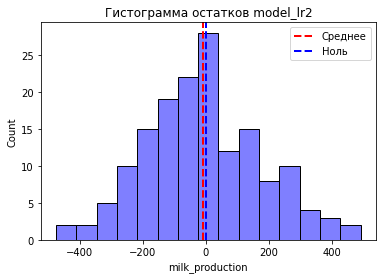

Среднее по остаткам -9.609


In [78]:
sns.histplot(y_test2 - pred2, kde=False, 
             bins=15, color = 'blue', alpha=0.5)
plt.title('Гистограмма остатков model_lr2')

plt.axvline((y_test2 - pred2).mean(), color='red', linestyle='dashed', linewidth=2, label='Среднее')
plt.axvline(0, color='blue', linestyle='dashed', linewidth=2, label='Ноль')
plt.legend()
plt.show()
print(f'Среднее по остаткам {(y_test2 - pred2).mean():.3f}')

У нашей модели увеличилось смещение влево. Получается что она еще больше начала преувеличивать свои предсказания по сравнению с реальными значениями. При этом видно, что распределение стало более равномерным, отсутствуют длинные хвосты.

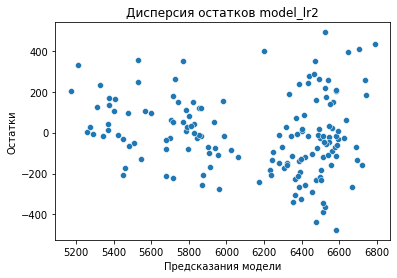

Дисперсия остатков 34743.60871060528


In [79]:
sns.scatterplot(x=pred2, y=y_test2 - pred2)
plt.xlabel('Предсказания модели')
plt.ylabel('Остатки')
plt.title('Дисперсия остатков model_lr2')
plt.show()

print(f'Дисперсия остатков {(y_test2 - pred2).var()}')

Судя по диаграмме рассеяния дисперсия у второй модели уменьшилась, но мы по прежнему наблюдаем увеличение плотности данных при увеличении значений целевого признака. 

##### Вывод

1) Коэффициент детерминации R2 у второй модели оказался выше - 0.830. Вторая модель на 2% ближе к истине по сравнению с предыдущей. Добавление новых признаков явно улучшило картину.

2) Анализ остатков показал нам, что модель начала предсказывать еще большие значения целевого признака, чем предыдущая. При этом распределение остатков улучшилось, а дисперсия уменьшилась - 34743.

#### Третья модель линейной регрессии

Третья модель будет отличаться от второй тем, что мы добавим в нее новый признак `dad_name`, который содержит в себе имя папы быка. Также в ходе корреляционного анализа было обнаружено отсутствие линейной зависимости между входными признаками `fat_content`, `protein_content` c целевым признаком `milk_production`. Вот как мы поступим с ними:

1) В ходе исследовательского анализа данных мы выяснили, что в столбце `fat_content`, где содержатся значения жирности молока, существует граница между подавляющим количеством наблюдений, где значение жирности выше 3.6%  и прочими наблюдениями по левую сторону этой границы. Добавим в датафрейм новый признак `fat_content_bin`, где будут бинарные значения `выше порога` и `ниже порога`

2) Что касается признака `protein_content`, то тут границу можно провести через среднее значение 3.076, превратив этот признак в бинарный `protein_content_bin`

In [80]:
def fat_content_bin(value):
    if value < 3.6:
        return 'ниже порога'
    else:
        return 'выше порога'
    
ferma_main['fat_content_bin'] = ferma_main['fat_content'].apply(fat_content_bin)


def protein_content_bin(value):
    if value < 3.076:
        return 'ниже порога'
    else:
        return 'выше порога'
    
ferma_main['protein_content_bin'] = ferma_main['protein_content'].apply(protein_content_bin)

ferma_main.sample(5)

,id,milk_production,efu,crude_protein,spr,breed,pasture_type,bull_breed,fat_content,protein_content,taste,age,dad_name,efu2,spr0915,fat_content_bin,protein_content_bin
70,72,5809,13.5,2093,0.895,РефлешнСоверинг,равнинное,Айдиал,3.61,3.079,не вкусно,более_2_лет,Барин,182.25,ниже порога,выше порога,выше порога
162,164,5566,12.1,1802,0.880,Вис Бик Айдиал,равнинное,Соверин,3.59,3.077,не вкусно,менее_2_лет,Барин,146.41,ниже порога,ниже порога,выше порога
602,604,6289,13.4,1899,0.940,Вис Бик Айдиал,равнинное,Айдиал,3.73,3.076,вкусно,более_2_лет,Буйный,179.56,выше порога,выше порога,выше порога
269,271,6597,14.2,2204,0.950,РефлешнСоверинг,равнинное,Соверин,3.74,3.079,не вкусно,более_2_лет,Барин,201.64,выше порога,выше порога,выше порога
383,385,5361,12.9,1947,0.890,Вис Бик Айдиал,холмистое,Соверин,3.34,3.078,вкусно,менее_2_лет,Барин,166.41,ниже порога,ниже порога,выше порога


Теперь перечислим наши входные признаки:

1) **Категориальные**: `breed`, `pasture_type`, `bull_breed`, `age`,  `dad_name`, `spr090`, `fat_content_bin`, `protein_content_bin`

2) **Количественные**: `crude_protein`, `efu2`

Такая вот картина! Теперь приступим к самой модели

In [81]:
features3 = ferma_main.drop(['milk_production', 'efu', 'spr', 'fat_content', 'protein_content', 'id', 'taste'], 1)
target3 = ferma_main['milk_production']

cat_col_name3 = ['breed', 
                 'pasture_type', 
                 'bull_breed', 
                 'age', 
                 'dad_name', 
                 'spr0915', 
                 'fat_content_bin', 
                 'protein_content_bin']
num_col_name3 = ['crude_protein', 'efu2']

X_train3, X_test3, y_train3, y_test3 = train_test_split(features3, target3, random_state=RANDOM_STATE)

#Кодируем категориальные признаки
encoder3 = OneHotEncoder(sparse=False, drop='first')
X_train3_ohe = encoder3.fit_transform(X_train3[cat_col_name3])
X_test3_ohe = encoder3.transform(X_test3[cat_col_name3])

encoder3_col_names = encoder3.get_feature_names()

#Масштабируем количественные признаки
scaler3 = StandardScaler()
X_train3_scaled = scaler3.fit_transform(X_train3[num_col_name3])
X_test3_scaled = scaler3.transform(X_test3[num_col_name3])

#Cоздаем датафреймы обработанных признаков и объединяем их в итоговые выборки с входными признаками
X_train3_ohe = pd.DataFrame(X_train3_ohe, columns=encoder3_col_names)
X_test3_ohe = pd.DataFrame(X_test3_ohe, columns=encoder3_col_names)

X_train3_scaled = pd.DataFrame(X_train3_scaled, columns=num_col_name3)
X_test3_scaled = pd.DataFrame(X_test3_scaled, columns=num_col_name3)

X_train3 = pd.concat([X_train3_ohe, X_train3_scaled], axis=1)
X_test3 = pd.concat([X_test3_ohe, X_test3_scaled], axis=1)

#Создадим и обучим нашу модель
model_lr3 = LinearRegression()
model_lr3.fit(X_train3, y_train3)
pred3 = model_lr3.predict(X_test3)

Считаем метрику R2 для model_lr3

In [82]:
print(f'Значение метрики R2 для модели model_lr3 = {r2_score(y_test3, pred3):.3f}')

Значение метрики R2 для модели model_lr3 = 0.836


А теперь посмотрим, что с остатками

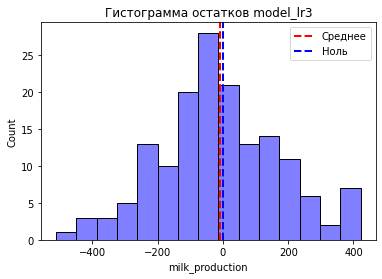

Среднее по остаткам -10.506


In [83]:
sns.histplot(y_test3 - pred3, kde=False, 
             bins=15, color = 'blue', alpha=0.5)
plt.title('Гистограмма остатков model_lr3')

plt.axvline((y_test3 - pred3).mean(), color='red', linestyle='dashed', linewidth=2, label='Среднее')
plt.axvline(0, color='blue', linestyle='dashed', linewidth=2, label='Ноль')
plt.legend()
plt.show()
print(f'Среднее по остаткам {(y_test3 - pred3).mean():.3f}')

У третьей модели немного увеличелось среднее по остаткам. Но незначительно. Распределение по прежнему можно считать нормальным, при этом присутствует небольшой пик у правого хвоста. 

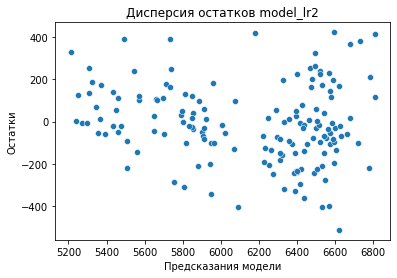

Дисперсия остатков 33644.43115988436


In [84]:
sns.scatterplot(x=pred3, y=y_test3 - pred3)
plt.xlabel('Предсказания модели')
plt.ylabel('Остатки')
plt.title('Дисперсия остатков model_lr2')
plt.show()

print(f'Дисперсия остатков {(y_test3 - pred3).var()}')

Судя по диаграмме рассеяния дисперсия остатков стала более равномерной. При этом само значение дисперсии немного уменьшилось. Остатки стали еще более случайными, чем в предыдущих моделях.

##### Вывод

1) Добавив новый признак в модель, а также изменив уже существующие, мы добились повышения метрики R2 аж до 0.836. Предсказания model_lr3 почти в 84% случаев ближе к истине, чем среднее значение.

2) Анализ остатков также показал нам, что мы добились необходимого результата! Диаграмма рассеяния показала более равномерную дисперсию остатков. Мы добились той самой случайности остатков, добавив новый признак `dad_name` и изменив существующие `fat_content` и `protein_content`. 

____

Мы обучили 3 модели линейной регрессии. 

Первую модель мы оставили без изменения первоначальных входных признаков и получили **R2 равную 0.811**. Анализ остатков показал нам, что **дисперсия остатков при увеличении целевого признака уменьшается. Присутствовала небольшая зависимость.**

Вторую модель мы обучили, исключив нелинейность признаков `spr` и `efu`. При этом, **мы добились увеличения R2 - 0.830**. Анализ остатков показал нам, что модель начала предсказывать чуть большие значения для целевой переменной, но при этом **распределение остатков стало более равномерным и случайным**. Хотя по прежнему **наблюдалась зависимость между увеличением значения целевого признака и дисперсии остатков**.

Для третьей модели мы добавили новый признак `dad_name`, а также перевели признаки `fat_content`, `protein_content` в бинарные для исключения нелинейности. Метрика **R2 увеличилась до 0.836**. При этом, анализ остатков показал нам, что нашими действиями мы **добились случайности остатков нашей модели**. Модель показала себя лучше предыдущих двух. 

Прежде чем решать какая модель лучше справилась с задачей, посчитаем значения метрик MAE, MSE, RMSE

In [85]:
print(f'MAE для model_lr {mean_absolute_error(y_test, pred)}')
print(f'MAE для model_lr2 {mean_absolute_error(y_test2, pred2)}')
print(f'MAE для model_lr3 {mean_absolute_error(y_test3, pred3)}')
print()
print(f'MSE для model_lr {mean_squared_error(y_test, pred)}')
print(f'MSE для model_lr2 {mean_squared_error(y_test2, pred2)}')
print(f'MSE для model_lr3 {mean_squared_error(y_test3, pred3)}')
print()
print(f'RMSE для model_lr {mean_squared_error(y_test, pred)**0.5}')
print(f'RMSE для model_lr2 {mean_squared_error(y_test2, pred2)**0.5}')
print(f'RMSE для model_lr3 {mean_squared_error(y_test3, pred3)**0.5}')

MAE для model_lr 157.34824894733188
MAE для model_lr2 146.35941257661744
MAE для model_lr3 143.04578584641962

MSE для model_lr 38584.28413990429
MSE для model_lr2 34614.63848327635
MSE для model_lr3 33540.51628093016

RMSE для model_lr 196.42882716114835
RMSE для model_lr2 186.05009670321687
RMSE для model_lr3 183.14070077656186


Все три метрики показали нам, что ошибка третьей модели наиболее близка к нулю, а значит точность ее предсказаний выше. Для предсказания используем третью модель. Рассчитаем доверительный интервал для ее предсказаний. Для начала нам нужно рассчитать стандартное отклонение ошибок нашей модели. Далее мы установим 95% уровень доверия. Из курса по статистике мы знаем, что 95% уровень доверия соответствует 1.96 std. Чтобы определить диапазон значений, в пределах которого с высокой вероятностью, находится истинное значение целевой переменной мы умножим 1.96 на стандартное отклонение ошибки нашей модели, а после рассчитаем минимум и максимум для построения доверительного интервала.

In [86]:
confidence_interval = 1.96 * np.std(y_test3 - pred3)

print(f'Нижняя граница доверительного интервала {pred3.mean() - confidence_interval}')
print(f'Верхняя граница доверительного интервала {pred3.mean() + confidence_interval}')


Нижняя граница доверительного интервала 5780.192554766924
Верхняя граница доверительного интервала 6496.92181530962


#### Предсказание по реальным данным

Теперь приступим к подготовке нашего датасета `cow_buy` и предсказанию удоя. Прежде чем это сделать, необходимо предобработать все входные признаки на примере нашей обучающей выборки. Что конкретно нужно сделать:

1) Добавить признаки `efu`, `spr`, `crude_prutein`, увеличенные на 5%. Для этого возьмем средние значения каждого признака из датасета `ferma_main` и увеличим их на 5%

2) Возвести в квадрат `efu`, создав новый столбец `efu2`

3) Преобразовать столбцы `spr`, `fat_content`, `protein_content` в бинарные признаки по подобию с `ferma_main`, добавив новые признаки `spr0915`, `fat_content_bin`, `protein_content_bin`

In [87]:
cow_buy['efu'] = ferma_main['efu'].mean() + ferma_main['efu'].mean()*0.05
cow_buy['spr'] = ferma_main['spr'].mean() + ferma_main['spr'].mean()*0.05
cow_buy['crude_protein'] = ferma_main['crude_protein'].mean() + ferma_main['crude_protein'].mean()*0.05

cow_buy['efu2'] = cow_buy['efu'] **2

cow_buy['spr0915'] = cow_buy['spr'].apply(spr_0915)
cow_buy['fat_content_bin'] = cow_buy['fat_content'].apply(fat_content_bin)
cow_buy['protein_content_bin'] = cow_buy['protein_content'].apply(protein_content_bin)

cow_buy.head()

,breed,pasture_type,bull_breed,dad_name,fat_content,protein_content,age,efu,spr,crude_protein,efu2,spr0915,fat_content_bin,protein_content_bin
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,233.361138,выше порога,ниже порога,выше порога
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532,233.361138,выше порога,ниже порога,выше порога
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,233.361138,выше порога,ниже порога,ниже порога
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,0.958744,2019.947532,233.361138,выше порога,ниже порога,ниже порога
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,233.361138,выше порога,выше порога,ниже порога


Датасет готов. Теперь перечислим переменные и можно начинать.

1) **Категориальные**: `breed`, `pasture_type`, `bull_breed`, `age`,  `dad_name`, `spr0915`, `fat_content_bin`, `protein_content_bin`

2) **Количественные**: `crude_protein`, `efu2`

In [88]:
real_features = cow_buy.drop(['efu', 'spr', 'fat_content', 'protein_content'], 1)

# Кодируем категориальные признаки
real_features_ohe = encoder3.transform(real_features[cat_col_name3])

# Масштабируем количественные признаки
real_features_scaled = scaler3.transform(real_features[num_col_name3])

# Объединяем признаки в один датасет
real_features_ohe = pd.DataFrame(real_features_ohe, columns=encoder3_col_names)
real_features_scaled = pd.DataFrame(real_features_scaled, columns=num_col_name3)
real_features = pd.concat([real_features_ohe, real_features_scaled], axis=1)

# Получаем предсказания
real_pred = model_lr3.predict(real_features)
real_pred

array([6543.32584655, 6277.15525732, 6269.61560206, 6604.03120785,
       6570.81001122, 6373.08408277, 6543.32584655, 6488.66372631,
       6269.61560206, 6347.74753865, 6391.58824989, 6584.59255177,
       6620.1661189 , 6105.88404474, 6269.61560206, 6604.03120785,
       6346.81304968, 6373.08408277, 6533.43892653, 6570.81001122])

Готово! Мы получили прогнозы по нашим данным. Перед этим мы обучили и проверили качество трех моделей линейной регрессии. Лучшей по всем метрикам себя показала model_lr3. Ее мы и использовали для предсказания удоя.

## Обучение модели логистической регрессии

Теперь нам нужно спрогнозировать категориальную переменную `taste`. Для этого обучим модель логистической регрессии. Чтобы это сделать, нам нужно подготовить признаки к обучению модели. После обучения оценим качество модели с помощью метрик `accuracy`, `precision`, `recall`. Чтобы в дальнейшем мы смогли подогнать порог классификации нашей модели используем матрицу ошибок и сделаем вывод о том, какая ошибка критичнее всего при покупке коровы: первого или второго рода. После сведения ошибки к нулю 

Решим какие переменные мы оставим для обучения модели:
1) Количественные: `crude_protein`, `efu2`

2) Категориальные: `breed`, `pasture_type`, `fat_content_bin`, `protein_content_bin`, `age`, `dad_name`, `spr0915`

Также стоит заранее обговорить, что для удобства стоит перевести значения столбца `taste` в бинарные числовые значения, где:
1) вкусно - 1

2) не вкусно - 0

In [89]:
def taste_bin(value):
    if value == 'вкусно':
        return 1
    else:
        return 0
    
ferma_main['taste_bin'] = ferma_main['taste'].apply(taste_bin)
ferma_main.head(5)

,id,milk_production,efu,crude_protein,spr,breed,pasture_type,bull_breed,fat_content,protein_content,taste,age,dad_name,efu2,spr0915,fat_content_bin,protein_content_bin,taste_bin
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный,201.64,ниже порога,ниже порога,выше порога,1
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик,163.84,ниже порога,ниже порога,выше порога,1
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин,196.00,ниже порога,ниже порога,ниже порога,0
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный,153.76,ниже порога,ниже порога,ниже порога,0
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин,163.84,ниже порога,выше порога,ниже порога,1


In [90]:
features_log = ferma_main.drop(['milk_production', 
                                'efu', 
                                'spr', 
                                'fat_content', 
                                'protein_content', 
                                'id', 
                                'taste', 
                                'taste_bin'], 1)
target_log = ferma_main['taste_bin']

cat_col_name_log = ['breed', 
                 'pasture_type', 
                 'dad_name', 
                 'age', 
                 'bull_breed', 
                 'spr0915', 
                 'fat_content_bin', 
                 'protein_content_bin']
num_col_name_log = ['crude_protein', 'efu2']

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(features_log, target_log, random_state=RANDOM_STATE)

# Масштабируем количественные признаки
scaler_log = StandardScaler()
X_train_log_scaled = scaler_log.fit_transform(X_train_log[num_col_name_log])
X_test_log_scaled = scaler_log.transform(X_test_log[num_col_name_log])

#Кодируем категориальные признаки
encoder_log = OneHotEncoder(sparse=False, drop='first')
X_train_log_encoded = encoder_log.fit_transform(X_train_log[cat_col_name_log])
X_test_log_encoded = encoder_log.transform(X_test_log[cat_col_name_log])

encoded_col_name_log = encoder_log.get_feature_names()

#Создаем и объединяем датафреймы
X_train_log_scaled = pd.DataFrame(X_train_log_scaled, columns=num_col_name_log)
X_test_log_scaled = pd.DataFrame(X_test_log_scaled, columns=num_col_name_log)

X_train_log_encoded = pd.DataFrame(X_train_log_encoded, columns=encoded_col_name_log)
X_test_log_encoded = pd.DataFrame(X_test_log_encoded, columns=encoded_col_name_log)

X_train_log = pd.concat([X_train_log_scaled, X_train_log_encoded], axis=1)
X_test_log = pd.concat([X_test_log_scaled, X_test_log_encoded], axis=1)

model_log = LogisticRegression()
model_log.fit(X_train_log, y_train_log)
pred_log = model_log.predict(X_test_log)

In [91]:
for feature_number, feature_name in enumerate(X_train_log.columns):
    weight = model_log.coef_[0, feature_number]
    print(f"{feature_name:<20}: {weight:+.6f}") 

crude_protein       : +0.215599
efu2                : +0.588398
x0_РефлешнСоверинг  : -0.100774
x1_холмистое        : +0.649578
x2_Буйный           : -0.173023
x2_Геркулес         : -0.315433
x2_Соловчик         : -0.332643
x3_менее_2_лет      : -0.033156
x4_Соверин          : -0.239443
x5_ниже порога      : +0.786274
x6_ниже порога      : +0.083276
x7_ниже порога      : -0.258883


Веса говорят нам о том, что больше всего на значение целевого признака влияют такие признаки, как ЭКЕ, Тип пастбища(холмистое), СПО

Модель готова. Теперь посчитаем значение accuracy, recall, precision

In [92]:
print(f'Значение accuracy {accuracy_score(y_test_log, pred_log):.6f}')
print(f'Значение precision {precision_score(y_test_log, pred_log):.6f}')
print(f'Значение recall {recall_score(y_test_log, pred_log):.6f}')

Значение accuracy 0.681529
Значение precision 0.686441
Значение recall 0.861702


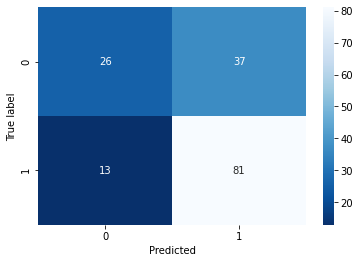

In [93]:
sns.heatmap(confusion_matrix(y_test_log, pred_log), annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

Accuracy нашей модели составила 0.688, есть куда стремиться. Значение метрики recall составило 0.862. Значение метрики precision составило 0.692 - именно ее нам необходимо повысить, т.к. по заказчику важно, чтобы как можно больше коров давали вкусное молоко. Ему не важно сколько коров дает невкусное молоко, главное чтобы "вкусных" коров было как модно больше. Поэтому работать мы будем именно с этой метрикой, уменьшая вероятность ошибки первого рода.

In [94]:
# Получаем вероятности
y_proba = model_log.predict_proba(X_test_log)[:, 1]
data = pd.DataFrame({'y_test_log': y_test_log, 'y_proba': y_proba}).sort_values(by='y_proba', ascending=False)

# Определение порогов и вычисление precision для каждого порога
thresholds = [round(i, 2) for i in np.linspace(0.1, 1, num=10, endpoint=False)]
values = []
columns = []

for i in thresholds:
    column_name = 'y_pred_' + str(i)
    data[column_name] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)
    precision = precision_score(data['y_test_log'], data[column_name], zero_division=1)
    values.append(precision)
    columns.append(column_name)

# Создаем датафрейм с результатами
thres = pd.DataFrame(list(zip(thresholds, values)), columns=['Порог', 'precision'])
print(thres)

   Порог  precision
0   0.10   0.598726
1   0.19   0.598726
2   0.28   0.606452
3   0.37   0.636364
4   0.46   0.661417
5   0.55   0.695238
6   0.64   0.803030
7   0.73   0.896552
8   0.82   1.000000
9   0.91   1.000000


Таким образом, при значении порога 0.82 ошибка первого рода сводится к нулю. Посчитаем значения метрик при измененном пороге.

In [95]:
# Предсказываем вероятности на новых данных
new_y_proba = model_log.predict_proba(X_test_log)[:, 1]

# Устанавливаем новый порог (в данном случае, 0.82)
new_threshold = 0.82

# Преобразуем вероятности в предсказания с учетом нового порога
new_pred_log = (new_y_proba >= new_threshold).astype(int)
print(f'Значение precision {precision_score(y_test_log, new_pred_log):.6f}')
print(f'Значение recall {recall_score(y_test_log, new_pred_log):.6f}')

Значение precision 1.000000
Значение recall 0.095745


Мы добились нужного результата. Значение метрики precision равно единице - ошибка первого рода свелась к нулю. Метрика recall показала нам, что модель в большинстве случаев присваивает классу 1 класс 0. Очень тщательный отбор коров с вкусным молоком. Предскажем вкус молока на датасете `cow_buy`

In [96]:
real_features_log = cow_buy.drop(['efu', 'spr', 'fat_content', 'protein_content'], 1)

# Кодируем категориальные признаки
real_features_ohe_log = encoder_log.transform(real_features_log[cat_col_name_log])

# Масштабируем количественные признаки
real_features_scaled_log = scaler_log.transform(real_features_log[num_col_name_log])

# Объединяем признаки в один датасет
real_features_ohe_log = pd.DataFrame(real_features_ohe_log, columns=encoded_col_name_log)
real_features_scaled_log = pd.DataFrame(real_features_scaled_log, columns=num_col_name_log)
real_features_log = pd.concat([real_features_ohe_log, real_features_scaled_log], axis=1)

# Получаем предсказания
real_pred_log = model_log.predict(real_features_log)
real_pred_log

array([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [97]:
# Предсказываем вероятности на новых данных
new_data_proba = model_log.predict_proba(real_features_log)[:, 1]

# Преобразуем вероятности в предсказания с учетом нового порога
new_data_predictions = (new_data_proba >= new_threshold).astype(int)
new_data_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

Готово. При выбранном пороге классификации только одна корова дает вкусное молоко.

## Итоговые выводы

Мы проделали большую работу по предсказанию удоя и качества молока. Добавим наши предсказания в датафрейм и сделаем вывод по проделанной работе.

In [98]:
cow_buy['taste'] =  pd.DataFrame(new_data_predictions, columns=['taste'])
cow_buy['milk_production'] = pd.DataFrame(real_pred, columns=['milk_production'])
cow_buy.head()

,breed,pasture_type,bull_breed,dad_name,fat_content,protein_content,age,efu,spr,crude_protein,efu2,spr0915,fat_content_bin,protein_content_bin,taste,milk_production
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,233.361138,выше порога,ниже порога,выше порога,0,6543.325847
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532,233.361138,выше порога,ниже порога,выше порога,0,6277.155257
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,233.361138,выше порога,ниже порога,ниже порога,0,6269.615602
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,0.958744,2019.947532,233.361138,выше порога,ниже порога,ниже порога,0,6604.031208
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,233.361138,выше порога,выше порога,ниже порога,0,6570.810011


In [99]:
cow_buy[(cow_buy['taste'] == 1)&(cow_buy['milk_production'] > 6000)]

,breed,pasture_type,bull_breed,dad_name,fat_content,protein_content,age,efu,spr,crude_protein,efu2,spr0915,fat_content_bin,protein_content_bin,taste,milk_production
12,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.68,3.046,более_2_лет,15.276162,0.958744,2019.947532,233.361138,выше порога,выше порога,ниже порога,1,6620.166119


В ходе работы по построению моделей машинного обучения для оценки рисков при покупке коров были созданы и обучены две модели:
1) Модель линейной регрессии предсказывала размер удоя для каждой купленной коровы при условии, что содержание сырого протеина, белка и ЭКЕ будут увеличены на 5%. В ходе работы выяснилось, что все коровы из датасета предположительно будут производить более 6000 кг удоя.

2) Модель логистической регрессии предсказывала будет ли вкусным молоко от этих коров. Чтобы минимизировать риски, при которых предсказание `вкусное молоко` будет неверным, мы увеличили порог, при котором молоко может считаться вкусным. Наша модель предсказала, что только одна корова будет давать вкусное молоко.

Таким образом, т.к. для нас важны и вкус и удой одновременно, только одна корова рекоммендуется к покупке. Также стоит отметить, что при оценке влияния признаков на предсказание вкусности молока большое значение имели ЭКЕ, СПО и Тип пастбища - холмистое. Возможно, если увеличить уровень ЭКЕ и СПО в корме для новых коров, а также обращать внимание на холмистый тип пастбища, то можно позволить себе преобрести больше коров у продавца. 

Теперь поговорим о самих моделях в рамках этой задачи:
1) Для улучшения качества модели линейной регрессии в датафрейми были добавлены новые признаки:

     - Столбец `efu2`, который содержит в себе значения столбца `efu` в квадрате
     
     - Добавлен новый бинарный признак `spr0915` где собраны отфильтрованные по порогу СПО 0.915 значения столбца `spr`
     
     - Добавлен новый бинарный признак `fat_content_bin` где собраны отфильтрованные по порогу Жирности 3.6% значения столбца `fat_content`

     - Добавлен новый бинарный признак `protein_content_bin` где собраны отфильтрованные по порогу Содержание белка 3.076% значения столбца `protein_content`
  
   В итоге мы добились улучшения качества модели по метрике R2 с 81% до 83%. Наша модель в 83% случаев предсказывает значения близкие к истине лучше, чем среднее

   Как вариант, для улучшения качества модели можно было поиграться с признаками `bull_breed` и `dad_name`, т.к. они имеют нелинейную зависимость друг с другом. А именно, можно было попробовать исключить признак `bull_breed`, т.к. `dad_name` уже несет в себе генетическую закономерность, в том числе и породу быка.

2) При анализе рисков для моделей логистической регрессии очень важно учесть какие риски допустими, а какие критичны. Исходя из того какой показатель для нас важнее мы вибираем на какую метрику нам опираться при исследовании. Так, например, если нам важно отследить отток клиентов и вовремя его предотвратить, отправив специальное предложение, стоит опираться на метрику recall (1- клиент уйдет, 0 - клиент останется) и повышать ее значение, минимизируя ошибку второго рода. А если, например нам необходимо обследовать клиента на наличие каки-либо заболеваний, ложные срабатывания могут привести к неприятным и неудобным ситуациям, дополнительным переживаниям и т.д. Поэтому тут важно учитывать количество ложноположительных предсказаний.